### Preliminaries

In [1]:
# Show all figures inline.  
%matplotlib inline

# Add olfaction-prediction to the Python path.  
import os
import sys
curr_path = os.getcwd()
gerkin_path = os.path.split(curr_path)[0]
olfaction_prediction_path = os.path.split(gerkin_path)[0]
sys.path.append(olfaction_prediction_path)
import opc_python

# Import numerical libraries.  
import numpy as np
from matplotlib.pyplot import plot

In [2]:
# Import generic utility modules I wrote to load the data from the tab-delimited text files and to score predictions.  
from opc_python.utils import loading, scoring

# Import the modules I wrote for actually shaping and fitting the data to the model.  
from opc_python.gerkin import dream,fit1
from opc_python.gerkin.fit1 import rfc_cv

In [3]:
# Load the perceptual descriptors data.  
perceptual_headers, perceptual_obs_data = loading.load_perceptual_data('training')
loading.format_leaderboard_perceptual_data()
# Show the perceptual metadata types and perceptual descriptor names.
print(perceptual_headers)

['Compound Identifier', 'Odor', 'Replicate', 'Intensity', 'Dilution', 'subject #', 'INTENSITY/STRENGTH', 'VALENCE/PLEASANTNESS', 'BAKERY', 'SWEET', 'FRUIT', 'FISH', 'GARLIC', 'SPICES', 'COLD', 'SOUR', 'BURNT', 'ACID', 'WARM', 'MUSKY', 'SWEATY', 'AMMONIA/URINOUS', 'DECAYED', 'WOOD', 'GRASS', 'FLOWER', 'CHEMICAL']


In [4]:
# Show the metadata and perceptual descriptor values for the first compound.
print(perceptual_obs_data[1])

['126', '4-Hydroxybenzaldehyde', False, 'high', '1/10', '1', 37, 60, 0, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
num_descriptors = len(perceptual_headers[6:])
num_subjects = 49
print('There are %d different perceptual descriptors and %d different subjects' % (num_descriptors,num_subjects))

There are 21 different perceptual descriptors and 49 different subjects


In [6]:
# Load the molecular descriptors data.  
molecular_headers, molecular_data = loading.load_molecular_data()
print("First ten molecular descriptor types are %s" % molecular_headers[:10])
print("First ten descriptor values for the first compound are %s" % molecular_data[0][:10])
total_size = len(set([int(row[0]) for row in molecular_data]))
print("We have molecular descriptors for %d unique molecules" % total_size)

First ten molecular descriptor types are ['CID', 'complexity from pubmed', 'MW', 'AMW', 'Sv', 'Se', 'Sp', 'Si', 'Mv', 'Me']
First ten descriptor values for the first compound are ['126', 93.1, 122.13, 8.142, 10.01, 15.305, 10.193, 16.664, 0.667, 1.02]
We have molecular descriptors for 476 unique molecules


In [7]:
training_size = len(set([int(row[0]) for row in perceptual_obs_data]))
print("We have perceptual data for %d unique molecules" % training_size)
remaining_size = total_size - training_size
print ("%d are left out for testing in the competition; half of these (%d) are used for the leaderboard." \
       % (remaining_size,remaining_size/2))

We have perceptual data for 338 unique molecules
138 are left out for testing in the competition; half of these (69) are used for the leaderboard.


In [8]:
print("There are %d rows in the perceptual data set (at least one for each subject and molecule)" % len(perceptual_obs_data))
print("%d of these are replicates (same subject and molecules)" % sum([x[2] for x in perceptual_obs_data]))

There are 35084 rows in the perceptual data set (at least one for each subject and molecule)
1960 of these are replicates (same subject and molecules)


In [9]:
all_CIDs = sorted(loading.get_CIDs('training')+loading.get_CIDs('leaderboard')+loading.get_CIDs('testset'))
DATA = '/Users/rgerkin/Dropbox/science/olfaction-prediction/data/'
import pandas

In [10]:
episuite = pandas.read_table('%s/DREAM_episuite_descriptors.txt' % DATA)
episuite.iloc[:,49] = 1*(episuite.iloc[:,49]=='YES ')
episuite.iloc[:,49]
episuite = episuite.iloc[:,2:].as_matrix()
episuite.shape

(476, 62)

In [11]:
verbal = pandas.read_table('%s/name_features.txt' % DATA, sep='\t', header=None)
verbal = verbal.as_matrix()[:,1:]
verbal.shape

(476, 11786)

In [12]:
morgan = pandas.read_csv('%s/morgan_sim.csv' % DATA)
morgan = morgan.as_matrix()[:,1:]
morgan.shape

(476, 2437)

In [13]:
with open('%s/derived/nspdk_r3_d4_unaug.svm' % DATA) as f:
    nspdk_dict = {}
    i = 0
    while True:
        x = f.readline()
        if(len(x)):
            key_vals = x.split(' ')[1:]
            for key_val in key_vals:
                key,val = key_val.split(':')
                if key in nspdk_dict:
                    nspdk_dict[key][all_CIDs[i]] = val
                else:
                    nspdk_dict[key] = {all_CIDs[i]:val}
            i+=1
            if i == len(all_CIDs):
                break
        else:
            break
nspdk_dict = {key:value for key,value in nspdk_dict.items() if len(value)>1}

In [14]:
nspdk = np.zeros((len(all_CIDs),len(nspdk_dict)))
for j,(feature,facts) in enumerate(nspdk_dict.items()):
    for CID,value in facts.items():
        i = all_CIDs.index(CID)
        nspdk[i,j] = value
nspdk.shape

(476, 6163)

In [15]:
nspdk_gramian = pandas.read_table('%s/derived/nspdk_r3_d4_unaug_gramian.mtx' % DATA, delimiter=' ', header=None)
nspdk_gramian = nspdk_gramian.as_matrix()[:len(all_CIDs),:]
nspdk_gramian.shape

(476, 2437)

In [16]:
molecular_data_types = ['dragon','dragon+episuite','dragon+verbal','dragon+morgan',
                                                          'dragon+nspdk','dragon+nspdk_gramian','dragon+all']
molecular_data = {mdt:molecular_data.copy() for mdt in molecular_data_types}
for i,line in enumerate(molecular_data['dragon']):
    CID = int(line[0])
    index = all_CIDs.index(CID)
    molecular_data['dragon+episuite'][i] = line + list(episuite[index])
    molecular_data['dragon+verbal'][i] = line + list(verbal[index])
    molecular_data['dragon+morgan'][i] = line + list(morgan[index])
    molecular_data['dragon+nspdk'][i] = line + list(nspdk[index])
    molecular_data['dragon+nspdk_gramian'][i] = line + list(nspdk_gramian[index])
    molecular_data['dragon+all'][i] = line + list(episuite[index]) + list(morgan[index]) + list(nspdk[index]) + list(nspdk_gramian[index])

### Create Molecular Matrix

In [17]:
X_training = {mdt:None for mdt in molecular_data_types}
X_leaderboard_other = {mdt:None for mdt in molecular_data_types}
X_leaderboard_int = {mdt:None for mdt in molecular_data_types}
X_testset_other = {mdt:None for mdt in molecular_data_types}
X_testset_int = {mdt:None for mdt in molecular_data_types}
X_all = {mdt:None for mdt in molecular_data_types}
for mdt in molecular_data_types:
    X_training[mdt],good1,good2,means,stds,imputer = dream.make_X(molecular_data[mdt],"training")
    X_leaderboard_other[mdt],good1,good2,means,stds,imputer = dream.make_X(molecular_data[mdt],"leaderboard",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
    X_leaderboard_int[mdt],good1,good2,means,stds,imputer = dream.make_X(molecular_data[mdt],"leaderboard",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
    X_testset_other[mdt],good1,good2,means,stds,imputer = dream.make_X(molecular_data[mdt],"testset",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
    X_testset_int[mdt],good1,good2,means,stds,imputer = dream.make_X(molecular_data[mdt],"testset",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
    X_all[mdt],good1,good2,means,stds,imputer = dream.make_X(molecular_data[mdt],['training','leaderboard'],good1=good1,good2=good2,means=means,stds=stds)

There are now 676 molecular vectors of length 4871, one for each molecule and dilution
The X matrix now has shape (676x3033) molecules by non-NaN good molecular descriptors
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors
There are now 814 molecular vectors of length 4871, one for each molecule and dilution
The X matrix now has shape (814x3033) molecules by non-N

In [18]:
Y_training_imp,imputer = dream.make_Y_obs('training',target_dilution=None,imputer='median')
Y_training_mask,imputer = dream.make_Y_obs('training',target_dilution=None,imputer='mask')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (676x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (676x21) molecules by perceptual descriptors, one for each subject
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (676x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (676x21) molecules by perceptual descriptors, one

In [19]:
Y_leaderboard,imputer = dream.make_Y_obs('leaderboard',target_dilution='gold',imputer='mask')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for each subject
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for eac

In [20]:
Y_leaderboard_noimpute,_ = dream.make_Y_obs('leaderboard',target_dilution='gold',imputer=None)

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for each subject
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for eac

In [21]:
Y_all_imp,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='median')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (138x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (138x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


In [22]:
Y_all_mask,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='mask')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (138x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (138x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


In [23]:
Y_all_zero,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='zero')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (138x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (138x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


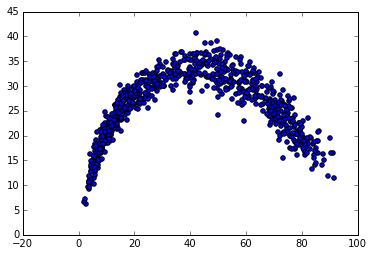

In [24]:
import matplotlib.pyplot as plt
plt.scatter(Y_all_mask['mean_std'][:,0],Y_all_mask['mean_std'][:,21])

### Data preparation

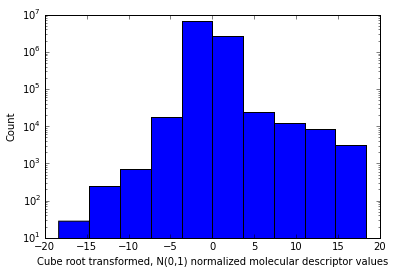

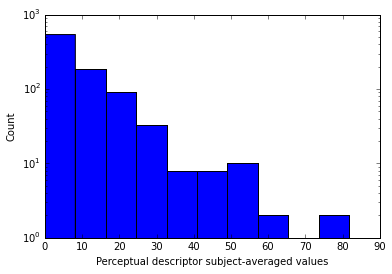

In [25]:
# Show the range of values for the molecular and perceptual descriptors.  
plt.hist(X_training['dragon+all'].ravel())
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Cube root transformed, N(0,1) normalized molecular descriptor values')
plt.figure()
plt.hist(Y_training_imp['mean_std'][:21].ravel())
plt.yscale('log')
plt.ylabel('Count')
_ = plt.xlabel('Perceptual descriptor subject-averaged values')

## Fitting and Generating Submission Files

In [26]:
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.cross_validation import ShuffleSplit
n_obs = len(Y_training_imp['mean_std'])

In [82]:
# How much should subjected be pooled for estimating individual subjects' responses?  
n_estimators_list = [5,18,50,150]
#rfcs = {subject:[None for _ in range(len(n_estimators_list))] for subject in range(1,50)}
X = X_all['dragon+all']
Y = Y_all_imp['subject']
for subject in range(1,50):
    for i,n_estimators in enumerate(n_estimators_list):
        if i<3:
            continue
        print(subject,n_estimators)
        rfcs[subject][i] = RandomForestRegressor(n_estimators=n_estimators,max_features=None,min_samples_leaf=1,
                                    max_depth=None,oob_score=True,n_jobs=-1,random_state=0)
        rfcs[subject][i].fit(X,Y[subject])

33 150
34 150
35 150
36 150
37 150
38 150
39 150
40 150
41 150
42 150
43 150
44 150
45 150
46 150
47 150
48 150
49 150


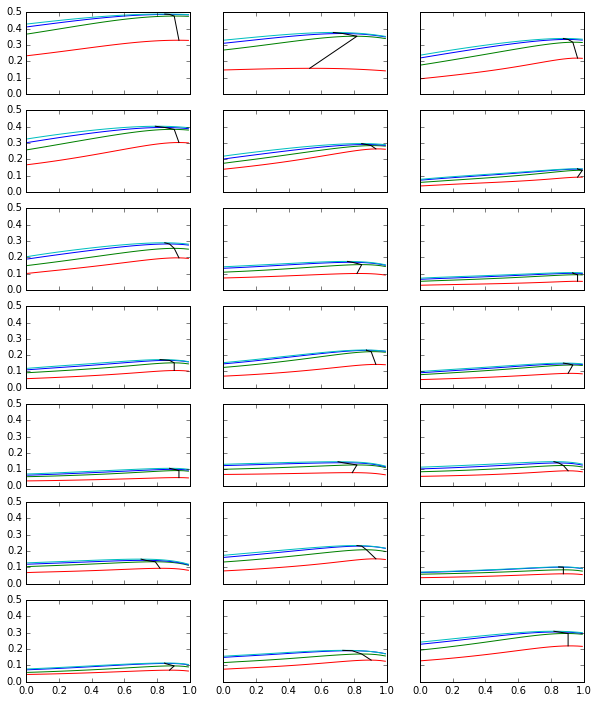

In [83]:
fig,axes = plt.subplots(7,3,sharex=True,sharey=True,figsize=(10,12))
a_list = np.linspace(0.01,0.99,35)
for col,ax in enumerate(axes.flat):
    rs = np.zeros((35,len(n_estimators_list)))
    x_max = np.zeros(len(n_estimators_list))
    y_max = np.zeros(len(n_estimators_list))
    for i,n_estimators in enumerate(n_estimators_list):
        prediction_pooled = np.zeros(rfcs[1][i].oob_prediction_.shape)
        for subject in range(1,50):
            prediction = rfcs[subject][i].oob_prediction_
            prediction_pooled += prediction
        prediction_pooled /= subject
        for j,a in enumerate(a_list):
            r = 0
            denom = 0
            for subject in range(1,50):
                observation = Y[subject][:,col]
                prediction = rfcs[subject][i].oob_prediction_[:,col]
                prediction_weighted = a*prediction_pooled[:,col] + (1-a)*prediction
                r_ = np.corrcoef(prediction_weighted,observation)[0,1]
                if not np.isnan(r_):
                    r += r_
                    denom += 1    
            r /= denom
            rs[j,i] = r
        #print(col,rs)
        ax.plot(a_list,rs[:,i],color=['r','g','b','c'][i])
        x_max[i] = a_list[np.argmax(rs[:,i])]
        y_max[i] = np.amax(rs[:,i])
    ax.plot(x_max,y_max,color='k')

In [85]:
import pickle
with open('/Users/rgerkin/Desktop/rfcs1_oob.pickle','wb') as f:
    pickle.dump(rfcs,f)

OSError: [Errno 22] Invalid argument

In [41]:
rfcs[18][i].__dict__

{'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, random_state=None,
            splitter='best'),
 'base_estimator_': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, random_state=None,
            splitter='best'),
 'bootstrap': True,
 'class_weight': None,
 'criterion': 'mse',
 'estimator_params': ('criterion',
  'max_depth',
  'min_samples_split',
  'min_samples_leaf',
  'min_weight_fraction_leaf',
  'max_features',
  'max_leaf_nodes',
  'random_state'),
 'estimators_': [DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, random_state=209652396,
    

In [35]:
# When do we want ExtraTrees instead of the usual RandomForest?
n_splits = 10
results = np.zeros((42,2,n_splits))
shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.2,random_state=0)
for col in range(42):
    rfc = RandomForestRegressor(n_estimators=20,max_features=None,min_samples_leaf=1,
                                max_depth=None,oob_score=False,n_jobs=-1,random_state=0)
    etc = ExtraTreesRegressor(n_estimators=20,max_features=None,min_samples_leaf=1,
                                max_depth=None,n_jobs=-1,random_state=0)
    for j,(train,test) in enumerate(shuffle_split):
        for i,estimator in enumerate([etc,rfc]):
            X = X_all['dragon+all']
            observed = Y_all_mask['mean_std'][:,col]
            estimator.fit(X[train,:],observed[train])
            predicted = estimator.predict(X[test,:])
            results[col,i,j] = np.corrcoef(predicted,observed[test])[1,0]
    means = results[col,:,:].mean(axis=1)
    sems = results[col,:,:].std(axis=1)/np.sqrt(n_splits)
    print('Desc. %d: [%.3f +/- %.3f], [%.3f +/- %.3f]' % \
          (col,means[0],sems[0],means[1],sems[1]))

Desc. 0: [0.664 +/- 0.020], [0.593 +/- 0.020]
Desc. 1: [0.626 +/- 0.011], [0.635 +/- 0.009]
Desc. 2: [0.557 +/- 0.071], [0.586 +/- 0.057]
Desc. 3: [0.678 +/- 0.024], [0.669 +/- 0.023]
Desc. 4: [0.705 +/- 0.022], [0.690 +/- 0.025]
Desc. 5: [0.365 +/- 0.017], [0.424 +/- 0.014]
Desc. 6: [0.557 +/- 0.048], [0.608 +/- 0.038]
Desc. 7: [0.247 +/- 0.020], [0.303 +/- 0.022]
Desc. 8: [0.269 +/- 0.024], [0.302 +/- 0.021]
Desc. 9: [0.531 +/- 0.027], [0.544 +/- 0.023]
Desc. 10: [0.426 +/- 0.034], [0.462 +/- 0.030]
Desc. 11: [0.415 +/- 0.019], [0.414 +/- 0.017]
Desc. 12: [0.180 +/- 0.020], [0.216 +/- 0.022]
Desc. 13: [0.395 +/- 0.014], [0.406 +/- 0.022]
Desc. 14: [0.494 +/- 0.021], [0.499 +/- 0.021]
Desc. 15: [0.289 +/- 0.023], [0.301 +/- 0.029]
Desc. 16: [0.494 +/- 0.044], [0.512 +/- 0.037]
Desc. 17: [0.260 +/- 0.042], [0.295 +/- 0.038]
Desc. 18: [0.235 +/- 0.036], [0.244 +/- 0.041]
Desc. 19: [0.494 +/- 0.026], [0.519 +/- 0.022]
Desc. 20: [0.574 +/- 0.025], [0.583 +/- 0.024]
Desc. 21: [-0.060 +/- 0

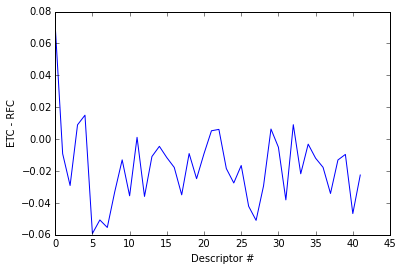

In [36]:
# Answer: Probably only for intensity.  
means = results[:,:,:].mean(axis=2)
sems = results[:,:,:].std(axis=2)/np.sqrt(n_splits)
plt.plot(means[:,0] - means[:,1])
plt.xlabel("Descriptor #")
plt.ylabel("ETC - RFC")

In [37]:
# How does performance increase with the number of features?  
n_splits = 3
n_features = [10,33,100,333,1000,3333,13914]
results = np.zeros((42,len(n_features),n_splits))
shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.2,random_state=0)
for col in range(42):
    for i,max_features in enumerate(n_features):
        rfc = RandomForestRegressor(n_estimators=100,max_features=max_features,min_samples_leaf=1,
                                max_depth=None,oob_score=False,n_jobs=-1,random_state=0)
        for j,(train,test) in enumerate(shuffle_split):
            X = X_all['dragon+all']
            observed = Y_all_mask['mean_std'][:,col]
            rfc.fit(X[train,:],observed[train])
            predicted = rfc.predict(X[test,:])
            results[col,i,j] = np.corrcoef(predicted,observed[test])[1,0]
    means = results[col,:,:].mean(axis=1)
    sems = results[col,:,:].std(axis=1)/np.sqrt(n_splits)
    print(('Desc. %d:'+len(n_features)*' [%.3f],') % \
          tuple([col]+[means[i] for i in range(len(n_features))]))

Desc. 0: [0.134], [0.150], [0.171], [0.235], [0.344], [0.547], [0.619],
Desc. 1: [0.635], [0.624], [0.630], [0.637], [0.642], [0.644], [0.669],
Desc. 2: [0.600], [0.595], [0.603], [0.615], [0.605], [0.616], [0.608],
Desc. 3: [0.669], [0.675], [0.682], [0.688], [0.694], [0.698], [0.705],
Desc. 4: [0.647], [0.648], [0.662], [0.670], [0.679], [0.694], [0.726],
Desc. 5: [0.411], [0.417], [0.414], [0.411], [0.405], [0.411], [0.407],
Desc. 6: [0.613], [0.656], [0.639], [0.658], [0.681], [0.688], [0.679],
Desc. 7: [0.314], [0.310], [0.326], [0.326], [0.325], [0.336], [0.360],
Desc. 8: [0.303], [0.311], [0.303], [0.311], [0.299], [0.314], [0.328],
Desc. 9: [0.552], [0.559], [0.563], [0.566], [0.560], [0.569], [0.576],
Desc. 10: [0.372], [0.386], [0.383], [0.389], [0.385], [0.405], [0.421],
Desc. 11: [0.280], [0.288], [0.302], [0.323], [0.363], [0.427], [0.452],
Desc. 12: [0.167], [0.166], [0.163], [0.173], [0.168], [0.175], [0.175],
Desc. 13: [0.400], [0.404], [0.405], [0.411], [0.409], [0.425

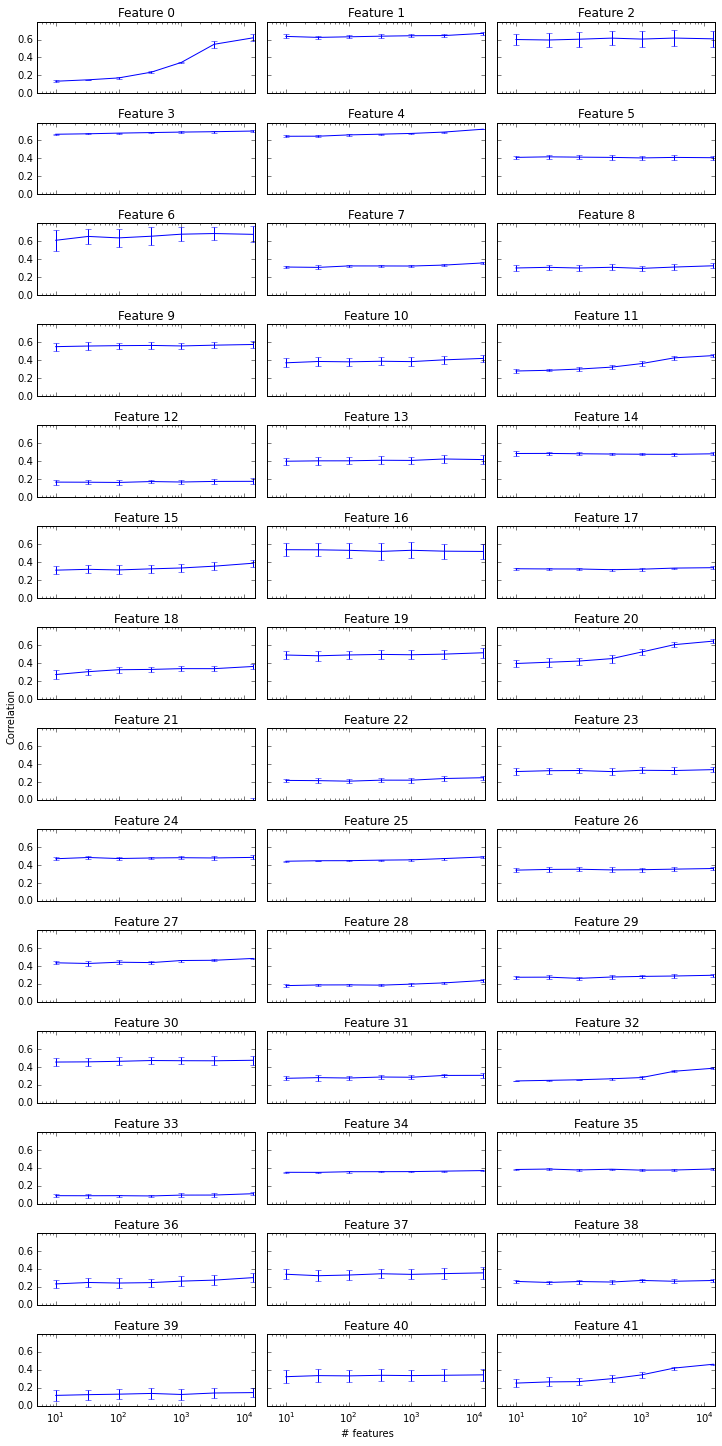

In [40]:
fig,ax = plt.subplots(14,3,sharex=True,sharey=True,figsize=(10,20))
for col in range(42):
    ax_ = ax[int(col / 3), col % 3]
    ax_.errorbar(n_features,results[col,:,:].mean(axis=1),results[col,:,:].std(axis=1)/np.sqrt(n_splits))
    ax_.set_xlim(5,15000)
    ax_.set_ylim(0,0.8)
    ax_.set_yticks(np.linspace(0,0.6,4))
    #ax_.set_xticklabels(n_features,rotation=45)
    ax_.set_xscale('log')
    ax_.set_title('Feature %d' % col)
plt.tight_layout()
fig.text(0.5, 0.00, '# features', ha='center')
fig.text(0.00, 0.5, 'Correlation', va='center', rotation='vertical')

In [42]:
# Does having more samples per leaf or less depth help?  
n_splits = 12
n_samples_leaf = [1,4,16,64]
n_depth = [2,6,15,32,None]
#results = np.zeros((42,len(n_samples_leaf),len(n_depth),n_splits))
shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.2,random_state=0)
for col in range(3,42):
    for i,min_samples_leaf in enumerate(n_samples_leaf):
        for j,max_depth in enumerate(n_depth):
            rfc = RandomForestRegressor(n_estimators=25,max_features=None,
                                            min_samples_leaf=min_samples_leaf,
                                            max_depth=max_depth,oob_score=False,
                                            n_jobs=-1,random_state=0)
            X = X_all['dragon+all']
            Y = Y_all_mask['mean_std'][:,col]
            for k,(train,test) in enumerate(shuffle_split):
                observed = Y[test]
                rfc.fit(X[train,:],Y[train])
                predicted = rfc.predict(X[test,:])
                results[col,i,j,k] = np.corrcoef(predicted,observed)[1,0]
            mean = results[col,i,j,:].mean()
            sem = results[col,i,j,:].std()/np.sqrt(n_splits)
            print('Feature %d: %s min samples per leaf, %s max depth: %.3f +/- %.3f' % (col,min_samples_leaf,max_depth,mean,sem))

Feature 3: 1 min samples per leaf, 2 max depth: 0.258 +/- 0.083
Feature 3: 1 min samples per leaf, 6 max depth: 0.310 +/- 0.095
Feature 3: 1 min samples per leaf, 15 max depth: 0.314 +/- 0.096
Feature 3: 1 min samples per leaf, 32 max depth: 0.315 +/- 0.096
Feature 3: 1 min samples per leaf, None max depth: 0.315 +/- 0.096
Feature 3: 4 min samples per leaf, 2 max depth: 0.259 +/- 0.083
Feature 3: 4 min samples per leaf, 6 max depth: 0.301 +/- 0.092
Feature 3: 4 min samples per leaf, 15 max depth: 0.306 +/- 0.093
Feature 3: 4 min samples per leaf, 32 max depth: 0.306 +/- 0.093
Feature 3: 4 min samples per leaf, None max depth: 0.306 +/- 0.093
Feature 3: 16 min samples per leaf, 2 max depth: 0.248 +/- 0.079
Feature 3: 16 min samples per leaf, 6 max depth: 0.278 +/- 0.085
Feature 3: 16 min samples per leaf, 15 max depth: 0.278 +/- 0.085
Feature 3: 16 min samples per leaf, 32 max depth: 0.278 +/- 0.085
Feature 3: 16 min samples per leaf, None max depth: 0.278 +/- 0.085
Feature 3: 64 min sa

In [45]:
import pickle
with open('data.pickle','wb') as f:
    pickle.dump(results,f)

In [59]:
results2[:,0,3]

array([  0.00000000e+00,   0.00000000e+00,  -1.69723722e-04,
         0.00000000e+00,   1.69704999e-03,  -1.61904458e-03,
         0.00000000e+00,   1.37203856e-04,   1.99234317e-04,
         0.00000000e+00,   3.85266740e-05,  -1.39141356e-04,
        -3.18332595e-04,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -2.32184524e-03,  -2.05099956e-05,
         2.70573941e-04,   0.00000000e+00,   0.00000000e+00,
        -1.02199441e-04,  -3.67148617e-04,  -2.51297232e-05,
         0.00000000e+00,   0.00000000e+00,  -2.10769807e-03,
         0.00000000e+00,  -1.48029305e-04,   2.95277257e-04,
         3.69270851e-05,   0.00000000e+00,   0.00000000e+00,
        -9.05272440e-05,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   9.19217603e-05,  -1.43068347e-04,
        -2.40110541e-04,   0.00000000e+00,   0.00000000e+00])

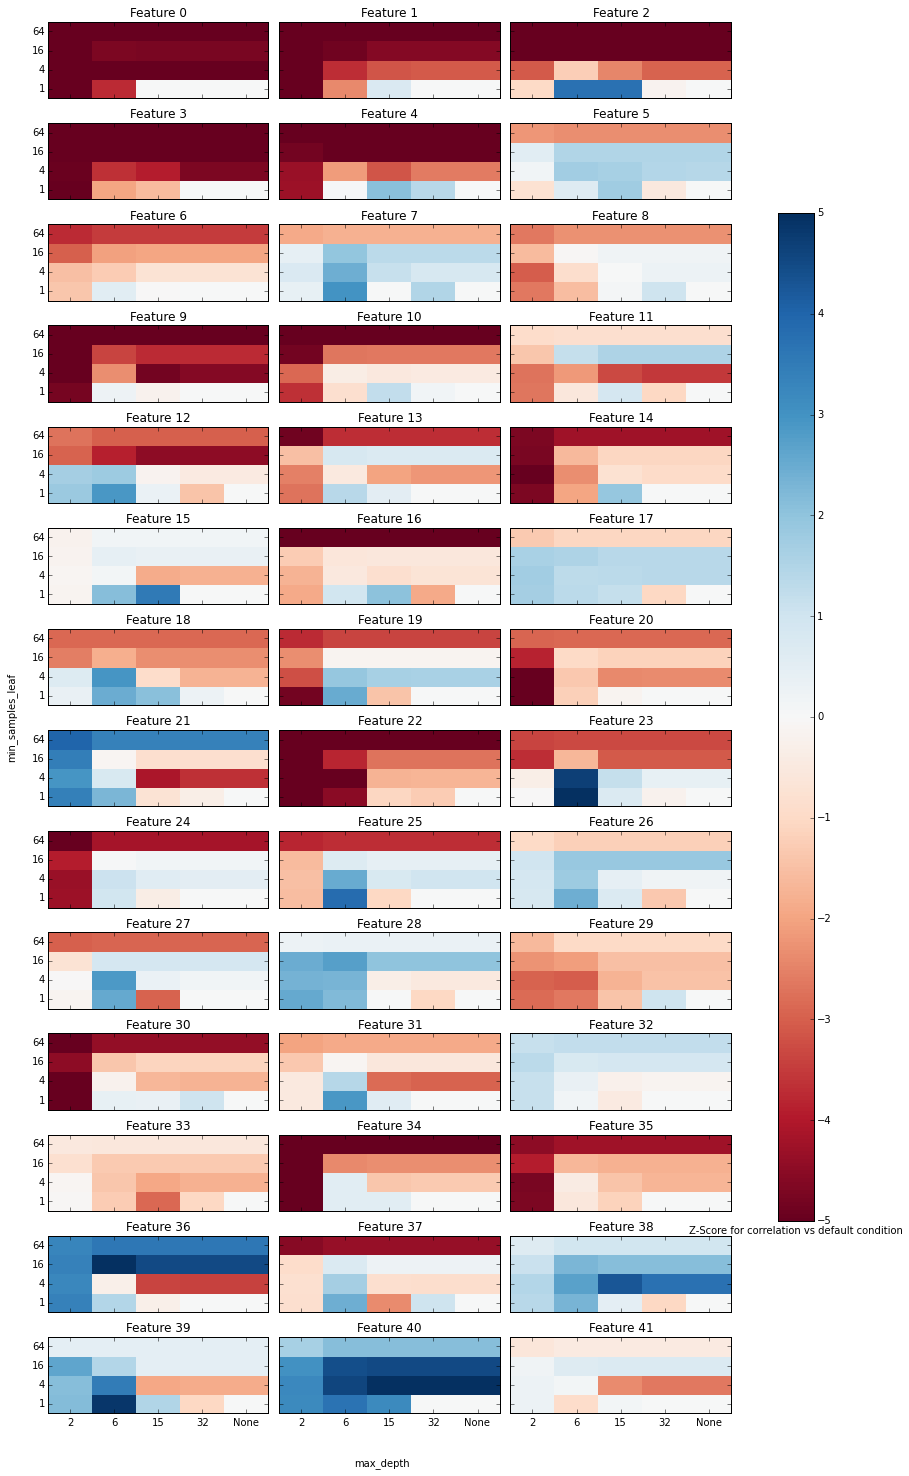

In [78]:
results2 = results - np.tile(results[:,0:1,4:5,:],(1,4,5,1)) # Subtract the no max depth, no min sample condition.  
results2 = results2[:,:,:,:n_splits] # Only 12 splits used.  
results2 = results2.mean(axis=3) / (results2.std(axis=3)/np.sqrt(n_splits)) 
results2[np.where(np.isnan(results2))] = 0

fig,axes = plt.subplots(14,3,sharex=True,sharey=True,figsize=(10,20))
for col,ax in enumerate(axes.flat):
    im = ax.pcolormesh(results2[col,:,:],vmin=-5,vmax=5,cmap='RdBu')
    ax.set_xticks(np.arange(5)+0.5)
    ax.set_xticklabels(n_depth)
    ax.set_yticks(np.arange(4)+0.5)
    ax.set_yticklabels(n_samples_leaf)
    ax.set_title('Feature %d' % col)
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
cbar_ax.set_xlabel('Z-Score for correlation vs default condition')
plt.colorbar(im, cax=cbar_ax)
fig.text(0.5, -0.02, 'max_depth', ha='center')
fig.text(-0.02, 0.5, 'min_samples_leaf', va='center', rotation='vertical')
plt.tight_layout()

/anaconda/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


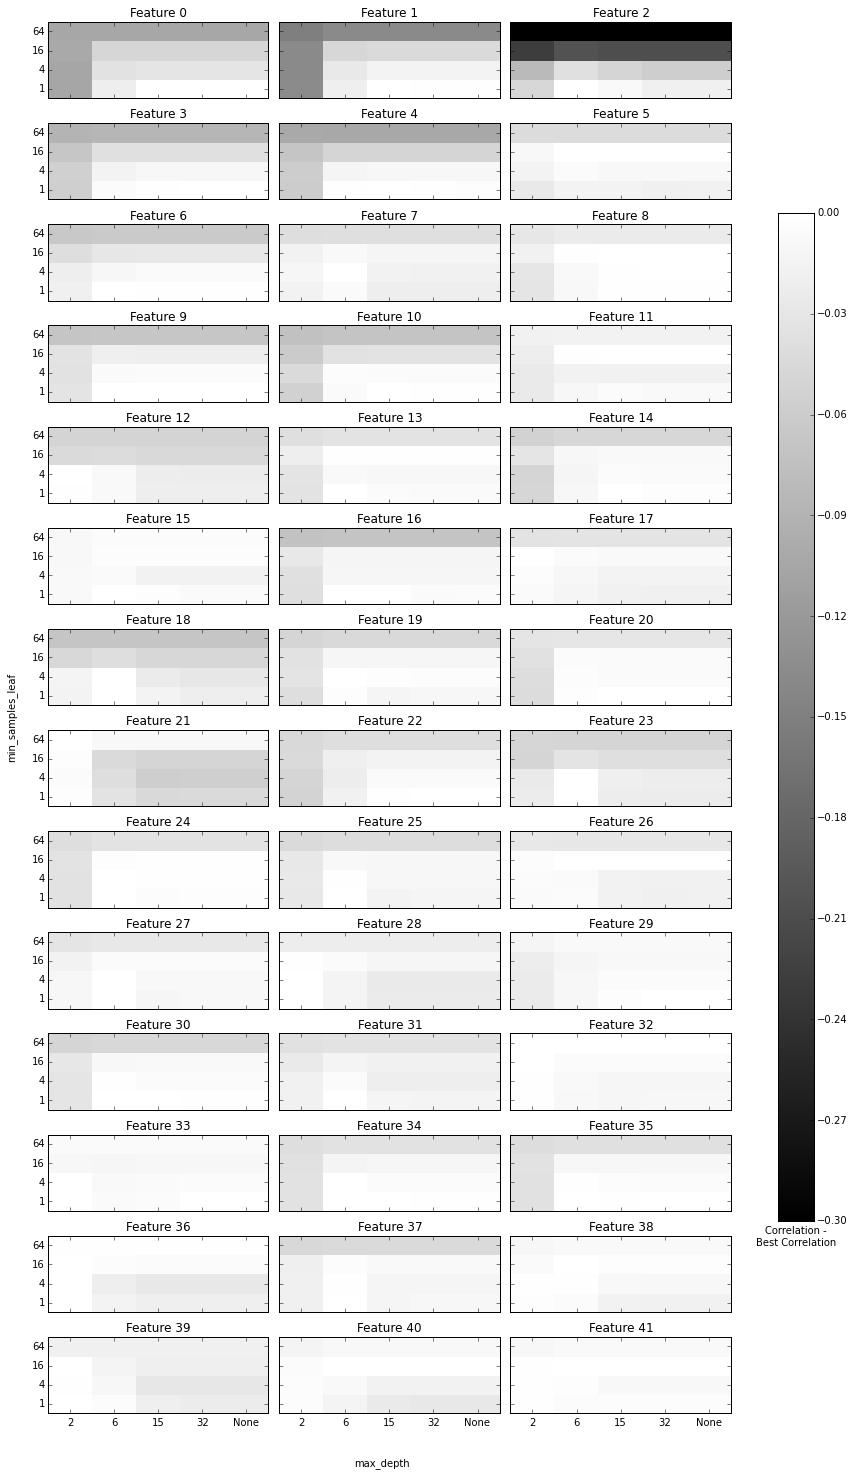

In [46]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(14,3,sharex=True,sharey=True,figsize=(10,20))
for col,ax in enumerate(axes.flat):
    im = ax.pcolormesh(results[col,:,:,:].mean(axis=2)-results[col,:,:,:].mean(axis=2).max(),vmin=-0.3,vmax=0.0,cmap='gray')
    ax.set_xticks(np.arange(5)+0.5)
    ax.set_xticklabels(n_depth)
    ax.set_yticks(np.arange(4)+0.5)
    ax.set_yticklabels(n_samples_leaf)
    ax.set_title('Feature %d' % col)
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
cbar_ax.set_xlabel('Correlation - \nBest Correlation')
plt.colorbar(im, cax=cbar_ax)
fig.text(0.5, -0.02, 'max_depth', ha='center')
fig.text(-0.02, 0.5, 'min_samples_leaf', va='center', rotation='vertical')
plt.tight_layout()

In [44]:
# Now we focus just on max_depth?  
n_splits = 10
n_depth = [2,5,8,12,16,25,None]
results = np.zeros((42,len(n_depth),n_splits))
shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.2,random_state=0)
for col in range(42):
    for j,max_depth in enumerate(n_depth):
        rfc = RandomForestRegressor(n_estimators=10,max_features=None,
                                        min_samples_leaf=1,
                                        max_depth=max_depth,oob_score=False,
                                        n_jobs=-1,random_state=0)
        X = X_all['dragon+all']
        Y = Y_all_mask['mean_std'][:,col]
        for k,(train,test) in enumerate(shuffle_split):
            observed = Y[test]
            rfc.fit(X[train,:],Y[train])
            predicted = rfc.predict(X[test,:])
            results[col,j,k] = np.corrcoef(predicted,observed)[1,0]
    means = results[col,:,:].mean(axis=1)
    sems = results[col,:,:].std(axis=1)/np.sqrt(n_splits)
    print(('Desc. %d:'+len(n_depth)*' [%.3f],') % \
          tuple([col]+[means[i] for i in range(len(n_depth))]))

Desc. 0: [0.509], [0.566], [0.577], [0.581], [0.579], [0.576], [0.576],
Desc. 1: [0.502], [0.600], [0.619], [0.623], [0.622], [0.618], [0.617],
Desc. 2: [0.547], [0.588], [0.593], [0.591], [0.584], [0.576], [0.573],
Desc. 3: [0.524], [0.624], [0.642], [0.640], [0.649], [0.641], [0.641],
Desc. 4: [0.548], [0.651], [0.664], [0.675], [0.663], [0.667], [0.672],
Desc. 5: [0.393], [0.415], [0.399], [0.407], [0.409], [0.399], [0.402],
Desc. 6: [0.589], [0.630], [0.606], [0.604], [0.604], [0.605], [0.604],
Desc. 7: [0.312], [0.330], [0.304], [0.283], [0.280], [0.290], [0.285],
Desc. 8: [0.216], [0.267], [0.282], [0.291], [0.287], [0.281], [0.286],
Desc. 9: [0.452], [0.541], [0.542], [0.537], [0.535], [0.534], [0.531],
Desc. 10: [0.335], [0.437], [0.449], [0.444], [0.451], [0.451], [0.447],
Desc. 11: [0.380], [0.394], [0.380], [0.389], [0.384], [0.383], [0.382],
Desc. 12: [0.257], [0.232], [0.209], [0.207], [0.204], [0.207], [0.208],
Desc. 13: [0.347], [0.414], [0.416], [0.402], [0.400], [0.404

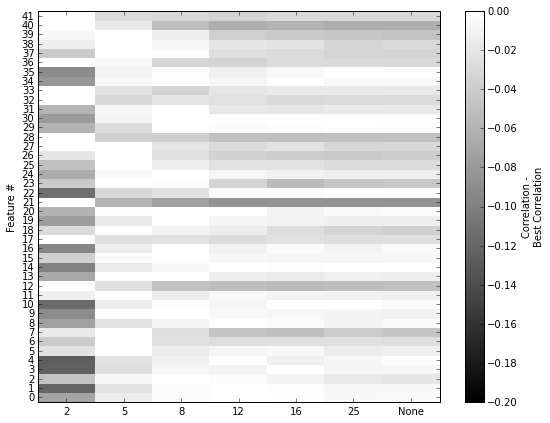

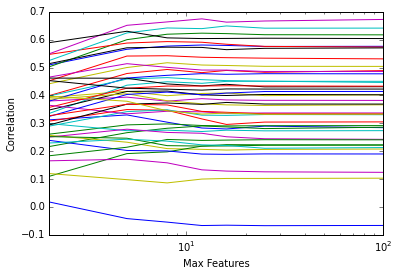

In [45]:
# Visualizing the dependence on n_depth
plt.figure(figsize=(9,7))
plt.pcolormesh(results.mean(axis=2) - np.tile(results.mean(axis=2).max(axis=1),(7,1)).T, vmin=-0.2, vmax=0.0)
plt.xticks(np.arange(len(n_depth))+0.5,n_depth)
plt.yticks(np.arange(42)+0.5,np.arange(42))
plt.ylim(0,42)
plt.ylabel('Feature #')
plt.set_cmap('gray')
ax = plt.colorbar()
ax.set_label('Correlation - \nBest Correlation')
plt.figure()
n_depth_ = [_ if _ is not None else 100 for _ in n_depth]
plt.plot(n_depth_,results[:,:,:].mean(axis=2).T)
plt.xscale('log')
plt.xlabel('Max Features')
plt.ylabel('Correlation')
_ = plt.xlim(2,100)

0 [ 0.71787708  1.0783493 ]
1 [ 0.53926198  1.11949144]
2 [ 0.92942102  1.16972938]
3 [ 0.77463092  1.13112086]
4 [ 0.86310257  1.14042383]
5 [ 1.14091214  1.30928986]
6 [ 0.90388954  1.14596541]
7 [ 0.92814885  1.21977815]
8 [ 1.01172533  1.22356058]
9 [ 0.89110208  1.19840522]
10 [ 0.94056219  1.21105179]
11 [ 0.89759906  1.23709485]
12 [ 1.00520858  1.27475276]
13 [ 0.91949363  1.23973119]
14 [ 1.02708055  1.27648987]
15 [ 1.05155092  1.26929085]
16 [ 0.95116679  1.19434156]
17 [ 1.13320597  1.3030216 ]
18 [ 1.07812377  1.25676318]
19 [ 0.90582241  1.13672918]
20 [ 0.80440721  1.12741897]


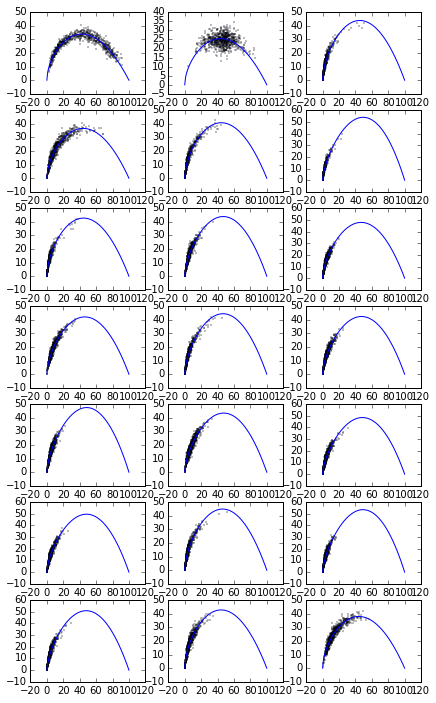

In [30]:
def f_transformation(x, k0=1.0, k1=1.0):
    return 100*(k0*(x/100)**(k1*0.5) - k0*(x/100)**(k1*2))
    
def sse(x, mean, stdev):
    predicted_stdev = f_transformation(mean, k0=x[0], k1=x[1])
    #predicted_mean = f_transformation2(predicted[i], k0=x[0], k1=x[1], k2=x[2])
    sse = np.sum((predicted_stdev - stdev)**2)
    return sse
    
fig,axes = plt.subplots(7,3,figsize=(7,12))
ax = axes.flat
f_coefs = {col:None for col in range(21)}
from scipy.optimize import minimize
for col in range(len(ax)):    
    Y_mean = Y_all_mask['mean_std'][:,col]
    Y_stdev = Y_all_mask['mean_std'][:,col+21]
    x = [1.0,1.0]
    res = minimize(sse, x, args=(Y_mean,Y_stdev), method='L-BFGS-B')
    print(col,res.x)
    f_coefs[col] = res.x
    ax[col].scatter(Y_mean,Y_stdev,s=0.1)
    x_ = np.linspace(0,100,100)
    ax[col].plot(x_,f_transformation(x_, k0=res.x[0], k1=res.x[1]))#, k2=res.x[2]))

In [31]:
# Balance between directly fitting stdev and applying a function to the fit of the mean.  

n_splits = 10
shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.2,random_state=0)
#predictions_mean = {i:[None]*n_splits for i in range(21)}
#predictions_stdev = {i:[None]*n_splits for i in range(21)}
for col in range(21):
    X = X_all['dragon+all']
    Y_mean = Y_all_mask['mean_std'][:,col]
    Y_stdev = Y_all_mask['mean_std'][:,col+21]
              
    for k,(train,test) in enumerate(shuffle_split):
        print(col,k)
        rfc_mean = RandomForestRegressor(n_estimators=30,max_features=None,
                                        min_samples_leaf=1,
                                        max_depth=None,
                                        n_jobs=-1,random_state=0)
        rfc_stdev = RandomForestRegressor(n_estimators=30,max_features=None,
                                        min_samples_leaf=1,
                                        max_depth=None,
                                        n_jobs=-1,random_state=0)
    
        rfc_mean.fit(X[train,:],Y_mean[train])
        rfc_stdev.fit(X[train,:],Y_stdev[train])
        predictions_mean[col][k] = rfc_mean.predict(X[test,:])
        predictions_stdev[col][k] = rfc_stdev.predict(X[test,:])

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
14 0
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
16 0
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
18 0
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
19 0
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
20 0
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9


0 1.0
1 0.0294117647059
2 1.0
3 0.617647058824
4 0.794117647059
5 0.970588235294
6 0.676470588235
7 0.882352941176
8 1.0
9 0.764705882353
10 0.911764705882
11 0.5
12 1.0
13 0.352941176471
14 0.676470588235
15 1.0
16 1.0
17 1.0
18 1.0
19 1.0
20 0.382352941176


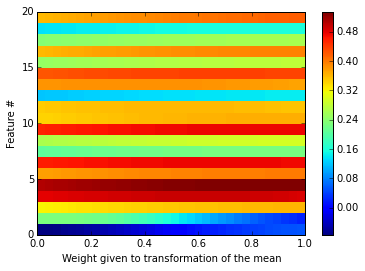

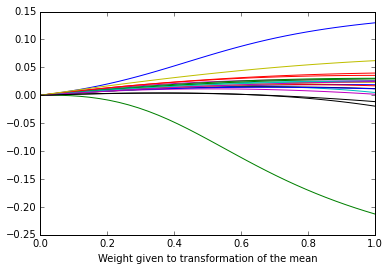

In [40]:
# Balance between directly fitting stdev and applying a function to the fit of the mean.  

results = np.zeros((21,n_splits,35))
#predictions_mean = {i:[None]*n_splits for i in range(21)}
#predictions_stdev = {i:[None]*n_splits for i in range(21)}
for col in range(21):
    X = X_all['dragon+all']
    Y_mean = Y_all_mask['mean_std'][:,col]
    Y_stdev = Y_all_mask['mean_std'][:,col+21]
              
    for k,(train,test) in enumerate(shuffle_split):
        observed = Y_stdev[test]
        p_m = predictions_mean[col][k]
        p_s = predictions_stdev[col][k]
        for i,a in enumerate(np.linspace(0,1,35)):
            p_s_transformed = f_transformation(p_m, k0=f_coefs[col][0], k1=f_coefs[col][0])
            predicted = a*p_s_transformed + (1-a)*p_s
            results[col,k,i] = np.corrcoef(predicted,observed)[1,0]
plt.pcolormesh(np.linspace(0,1,35),np.arange(21),results.mean(axis=1))# - np.tile(results.mean(axis=1).max(axis=1),(35,1)).T)
plt.xlabel('Weight given to transformation of the mean')
plt.ylabel('Feature #')
plt.colorbar()
plt.figure()
plt.plot(np.linspace(0,1,35),results.mean(axis=1).T-results.mean(axis=1)[:,0])
plt.xlabel('Weight given to transformation of the mean')
for col in range(21):
    max_loc = np.argmax(results.mean(axis=1)[col,:])
    print(col,np.linspace(0,1,35)[max_loc])

In [ ]:
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.cross_validation import ShuffleSplit
col = 1
rfc = RandomForestRegressor(n_estimators=25,max_features=None,
                            min_samples_leaf=1,
                            max_depth=None,oob_score=True,
                            n_jobs=-1,random_state=0)
n_obs = int(len(Y_all_mask['mean_std'][:,col])/2)
n_splits = 10
shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.2,random_state=0)

X = X_all
Y = Y_all_mask['mean_std']
rs = np.zeros((n_splits,3))
for k,(train,test) in enumerate(shuffle_split):
    train = np.concatenate((2*train,2*train+1))
    test = np.concatenate((2*test,2*test+1))
    assert len(set(train).intersection(test))==0
    
    # Intensity fitting
    rfc.fit(X[train,:],Y[train,0])
    int_predicted_oob = rfc.oob_prediction_
    int_predicted = rfc.predict(X[test,:])
    
    # Naive ple fitting
    int_observed = Y[test,0]
    ple_observed = Y[test,1]
    rfc.fit(X[train,:],Y[train,1])
    ple_predicted = rfc.predict(X[test,:])
    r1 = np.corrcoef(ple_predicted,ple_observed)[1,0]
    
    # ple fitting with oob intensity predictions
    X_train2 = np.hstack((X[train,:],int_predicted_oob.reshape(-1,1)))
    X_test2 = np.hstack((X[test,:],int_predicted.reshape(-1,1)))
    rfc.fit(X_train2,Y[train,1])
    ple_predicted = rfc.predict(X_test2)
    r2 = np.corrcoef(ple_predicted,ple_observed)[1,0]
    
    # ple fitting with exact intensities
    X_train3 = np.hstack((X[train,:],Y[train,0].reshape(-1,1)))
    rfc.fit(X_train3,Y[train,1])
    ple_predicted = rfc.predict(X_test2)
    r3 = np.corrcoef(ple_predicted,ple_observed)[1,0]
    
    print('%.2f %.2f %.2f' % (r1,r2,r3))
    rs[k,0] = r1
    rs[k,1] = r2
    rs[k,2] = r3

In [26]:
write = True # Set to True to actually generate the prediction files.  
n_estimators = 1000 # Set this to a high number (e.g. 1000) to get a good fit.  

# Best parameters, determined independently.  
max_features = {'int':{'mean':None,'sigma':None},
                'ple':{'mean':None,'sigma':None},
                'dec':{'mean':None,'sigma':None}}
min_samples_leaf = {'int':{'mean':1,'sigma':4},
                'ple':{'mean':1,'sigma':1},
                'dec':{'mean':1,'sigma':1}}
max_depth = {'int':{'mean':None,'sigma':2},
                'ple':{'mean':10,'sigma':10},
                'dec':{'mean':10,'sigma':10}}
et = {'int':{'mean':True,'sigma':True},
                'ple':{'mean':False,'sigma':False},
                'dec':{'mean':False,'sigma':False}}
#et['int'] = {'mean':False,'sigma':False} # Uncomment to get a correct score estimate, or leave commented to get best fit.  
use_mask = {'int':{'mean':False,'sigma':True},
                'ple':{'mean':False,'sigma':True},
                'dec':{'mean':False,'sigma':True}}

In [27]:
for mdt in molecular_data_types:
    print(mdt)
    loading.make_prediction_files(rfcs_leaderboard[mdt],X_leaderboard_int[mdt],X_leaderboard_other[mdt],
                                  'leaderboard_%s' % mdt,2,Y_test=Y_leaderboard_noimpute,write=False)

dragon
Score: 8.614029; rs = 0.658,0.517,0.522,0.385,0.244,0.479
dragon+episuite
Score: 8.716942; rs = 0.665,0.509,0.535,0.372,0.238,0.487
dragon+verbal
Score: 8.299890; rs = 0.662,0.498,0.506,0.260,0.274,0.468
dragon+morgan
Score: 8.746169; rs = 0.650,0.532,0.535,0.330,0.272,0.492
dragon+nspdk
Score: 9.138397; rs = 0.684,0.577,0.551,0.447,0.256,0.500
dragon+nspdk_gramian
Score: 8.953301; rs = 0.633,0.571,0.543,0.429,0.233,0.499
dragon+all
Score: 9.055417; rs = 0.648,0.573,0.555,0.371,0.273,0.504


In [28]:
rs_ = [[0.658,0.517,0.522,0.385,0.244,0.479],[0.665,0.509,0.535,0.372,0.238,0.487],[0.662,0.498,0.506,0.260,0.274,0.468],
[0.650,0.532,0.535,0.330,0.272,0.492],[0.684,0.577,0.551,0.447,0.256,0.500],[0.655,0.551,0.535,0.269,0.311,0.486]]
for i,challenge in enumerate(rs_):
    print(molecular_data_types[i]+'\t'.join(str(x) for x in challenge))
        

dragon0.658	0.517	0.522	0.385	0.244	0.479
dragon+episuite0.665	0.509	0.535	0.372	0.238	0.487
dragon+verbal0.662	0.498	0.506	0.26	0.274	0.468
dragon+morgan0.65	0.532	0.535	0.33	0.272	0.492
dragon+nspdk0.684	0.577	0.551	0.447	0.256	0.5
dragon+all0.655	0.551	0.535	0.269	0.311	0.486


In [29]:
rfcs,score,rs = fit2.rfc_final(X_all,Y_all_imp['mean_std'],Y_all_mask['mean_std'],
                            max_features,min_samples_leaf,max_depth,et,use_mask,
                            n_estimators=n_estimators)

For subchallenge 2:
	Score = 2.83
	int_mean = 1.000
	int_sigma = 0.126
	ple_mean = 0.009
	ple_sigma = -0.010
	dec_mean = 0.133
	dec_sigma = 0.072


In [30]:
loading.make_prediction_files(rfcs,X_testset_int,X_testset_other,'testset',2,write=False)

{'mean_std': array([[ 33.26530612,  44.62244898,   2.12244898, ...,   9.93389033,
          10.11045229,  21.72142009],
        [ 12.95918367,  48.15306122,   0.91836735, ...,   7.59583474,
          18.41829388,  22.26213039],
        [ 21.16326531,  44.62244898,   8.12244898, ...,   4.7887756 ,
           8.37787436,  24.78012562],
        ..., 
        [ 39.53061224,  59.50204082,   3.82780612, ...,  12.27196668,
          22.87507041,  19.62084018],
        [ 18.3877551 ,  57.82653061,   1.42212675, ...,   8.39165909,
          14.20939341,  23.09079336],
        [ 29.08163265,  49.21836735,   3.95918367, ...,  11.30602357,
          31.18954828,  22.55003619]]), 'subject': {}}